<a href="https://colab.research.google.com/github/brunoodon/mvp_sprintII/blob/main/MVP_SprintII(B).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP - Machine Learning & Analytics - Sprint II(B)
### Bruno Odon

## Descrição do problema

Instalando as bibliotecas TensorFlow e Keras

In [3]:
!pip install tensorflow
!pip install keras

In [4]:
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import models
from keras import optimizers
from tensorflow.keras.preprocessing import image
import os
from sklearn.model_selection import train_test_split
import shutil
import random
import math
import numpy as np
import zipfile
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from datetime import datetime
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
import sklearn.metrics as skm
import itertools
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Esta função imprime e plota a matriz de confusão.
    A normalização pode ser aplicada definindo `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusão normalizada")
    else:
        print('Matriz de confusão sem normalização')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Label real')
    plt.xlabel('Label predito')

In [6]:
!mkdir -pv datasets/{music_train,music_test}
!wget 'https://raw.githubusercontent.com/brunoodon/mvp_sprintII/main/music_train.zip' -P datasets/
!wget 'https://raw.githubusercontent.com/brunoodon/mvp_sprintII/main/music_test.zip' -P datasets/

mkdir: created directory 'datasets'
mkdir: created directory 'datasets/music_train'
mkdir: created directory 'datasets/music_test'
--2023-07-19 01:52:15--  https://raw.githubusercontent.com/brunoodon/mvp_sprintII/main/music_train.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10632185 (10M) [application/zip]
Saving to: ‘datasets/music_train.zip’

music_train.zip     100%[===================>]  10.14M  --.-KB/s    in 0.05s   

2023-07-19 01:52:16 (191 MB/s) - ‘datasets/music_train.zip’ saved [10632185/10632185]

--2023-07-19 01:52:16--  https://raw.githubusercontent.com/brunoodon/mvp_sprintII/main/music_test.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.gith

80% para treino e 20% para teste

In [7]:
dataset = 'https://raw.githubusercontent.com/brunoodon/mvp_sprintII/main/music.zip'
train = 'datasets/music_train.zip'
test = 'datasets/music_test.zip'
dest_train = 'datasets/music_train'
dest_test = 'datasets/music_test'
with zipfile.ZipFile(train,'r') as zip_ref:
    zip_ref.extractall(dest_train)
print(os.listdir(dest_train))
with zipfile.ZipFile(test,'r') as zip_ref:
    zip_ref.extractall(dest_test)
print(os.listdir(dest_test))

['1634117704444_Mixer mackie for sale.jpg', '1634117899869_yamaha psr2000 for sale.jpg', '1634110111179_Box Guitar Diviser for sale.jpg', '1634110346646_MAX Professional 4 Channel USB Interface  Mixer with Mobile Output for sale.jpg', '1634111875815_YAMAHA PSR  125 Electric Keyboard for sale.jpg', '1634112047058_PV SP2G TOPS speakers for sale.jpg', '1634118001110_5 String Bass Guitar for sale.jpg', '1634110942392_Piano Center Kohuwala for sale.jpg', '1634110701497_Guitargfx8 Paddle for sale.jpg', '1634113404318_Bc Original Speakers for sale.jpg', '1634117840230_Yamaha Acoustic Drum for sale.jpg', '1634118004234_Suzuki Semi Acoustic Guitars  Box for sale.jpg', '1634111149872_Yamaha Psr S700 for sale.jpg', '1634111518613_Crown Amp for sale.jpg', '1634110840753_Epiphone EJ200CE 42 Jumbo Acoustic Solid Wood Guitar for sale.jpg', '1634110987384_Yamaha SY77 Music Synthesizer for sale.jpg', '1634110230870_Electric Guitar for sale.jpg', '1634117676023_Arabic Darbuka for sale.jpg', '16341125536

In [8]:
batch_size = 32
img_height = 224
img_width = 224
num_classes = 5

In [9]:
#verificando o número de imagens que foram extraídas
path_train='datasets/music_train/'
print(f"Temos um total de {len(os.listdir(path_train))} imagens para o treinamento e avaliação do modelo de deep learning")

path_test='datasets/music_test/'
print(f"Temos um total de {len(os.listdir(path_test))} imagens para o teste do modelo de deep learning")

#exemplos de algumas imagens extraídas
print(f"Primeiras 20 imagens: \n {os.listdir(path_train)[:20]}")

#exemplos de algumas imagens extraídas
print(f"Primeiras 20 imagens: \n {os.listdir(path_test)[:20]}")

Temos um total de 2596 imagens para o treinamento e avaliação do modelo de deep learning
Temos um total de 648 imagens para o teste do modelo de deep learning
Primeiras 20 imagens: 
 ['1634117704444_Mixer mackie for sale.jpg', '1634117899869_yamaha psr2000 for sale.jpg', '1634110111179_Box Guitar Diviser for sale.jpg', '1634110346646_MAX Professional 4 Channel USB Interface  Mixer with Mobile Output for sale.jpg', '1634111875815_YAMAHA PSR  125 Electric Keyboard for sale.jpg', '1634112047058_PV SP2G TOPS speakers for sale.jpg', '1634118001110_5 String Bass Guitar for sale.jpg', '1634110942392_Piano Center Kohuwala for sale.jpg', '1634110701497_Guitargfx8 Paddle for sale.jpg', '1634113404318_Bc Original Speakers for sale.jpg', '1634117840230_Yamaha Acoustic Drum for sale.jpg', '1634118004234_Suzuki Semi Acoustic Guitars  Box for sale.jpg', '1634111149872_Yamaha Psr S700 for sale.jpg', '1634111518613_Crown Amp for sale.jpg', '1634110840753_Epiphone EJ200CE 42 Jumbo Acoustic Solid Wood Gu

In [47]:
from sklearn.preprocessing import FunctionTransformer
import re
#Criando um DataFrame com as informações das imagens

images = os.listdir(path_train)
labels, heights, widths, channels, filesize, files = [], [], [], [], [], []

# Loop que percorre cada uma das imagens extraídas
for fname in images:
    try:
      inst_type = str(fname)[14:].replace('.jpg', '').replace('for sale', '')
      if "Accoustic Guitar" in inst_type:
        name = "Accoustic Guitar"
        files.append(fname)
        labels.append(name)
      if ("Guitar" or "Guitar" or "Guitars" or "GUITAR" or "guitar") in inst_type:
        name = "Guitar"
        files.append(fname)
        labels.append(name)
      if "Piano" in inst_type:
        name = "Piano"
        files.append(fname)
        labels.append(name)
      if "Keyboard" in inst_type:
        name = "Keyboard"
        files.append(fname)
        labels.append(name)
      if "Speaker" in inst_type:
        name = "Speaker"
        files.append(fname)
        labels.append(name)
      if ("Mic" or "Micophone") in inst_type:
        name = "Microphone"
        files.append(fname)
        labels.append(name)
      if ("Bass Guitar" or "Bass") in inst_type:
        name = "Bass Guitar"
        files.append(fname)
        labels.append(name)
      if "Violin" in inst_type:
        name = "Violin"
        files.append(fname)
        labels.append(name)
      if ("DRUM" or "Drum" or "Drums" or "DRUMS") in inst_type:
        name = "Drums"
        files.append(fname)
        labels.append(name)
      if name != '':
        img_shape = mpimg.imread(path_train+fname).shape
        heights.append(img_shape[0])
        widths.append(img_shape[1])
        channels.append(img_shape[2])
        filesize.append(os.path.getsize(path_train+fname))
    except:
      print('Não foi possível')

#df = pd.DataFrame({'images': files, 'class': labels, 'height': heights, 'width': widths, 'channels': channels, 'filesize': filesize})
df = pd.DataFrame({'images': files, 'class': labels})
df.tail(100)
# Criação do dataset


,images,class
1098,1634117405100_Electric Guitar for sale.jpg,Guitar
1099,1634117400096_Guitar for sale.jpg,Guitar
1100,1634113406849_Fender CD60 NAT DS V2 Guitar for...,Guitar
1101,1634112912596_Japanese Semi Acoustic Guitar f...,Guitar
1102,1634113467647_Shure SM58 Original Mic for sale...,Microphone
...,...,...
1193,1634117553841_Semiacoustick Guitar for sale.jpg,Guitar
1194,1634110420848_Amplifier with Speakers for sale...,Speaker
1195,1634110992301_Tik Tok Mic for sale.jpg,Microphone
1196,1634112350643_Shure SM7B Cardioid Dynamic Voc...,Microphone


Guitar              543
Speaker             174
Microphone          172
Keyboard            113
Piano                87
Violin               52
Bass Guitar          49
Drums                 5
Accoustic Guitar      3
Name: class, dtype: int64


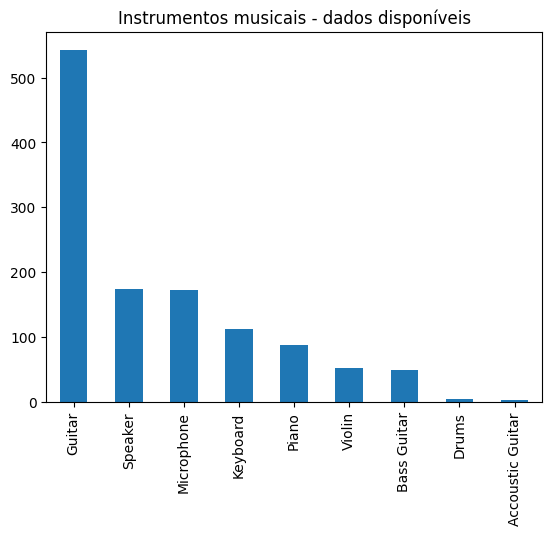

In [48]:
#Visualizando a proporção de imagens por classe
print((df['class']).value_counts())
instruments_count = df['class'].value_counts().plot.bar(title='Instrumentos musicais - dados disponíveis')

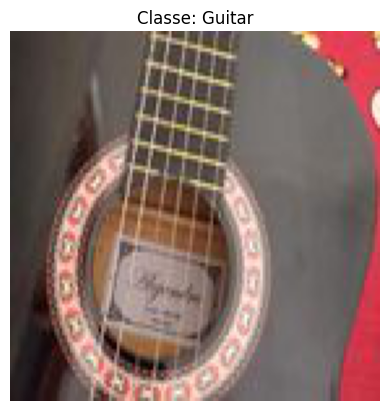

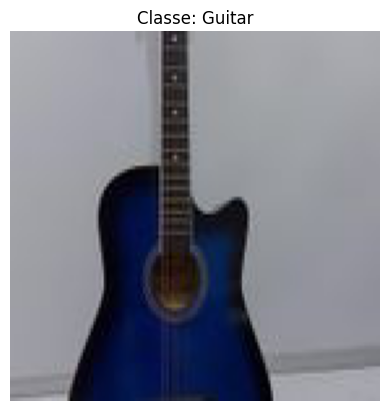

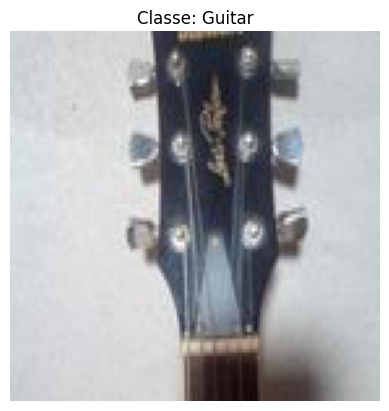

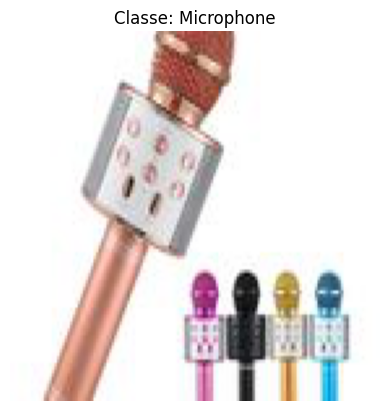

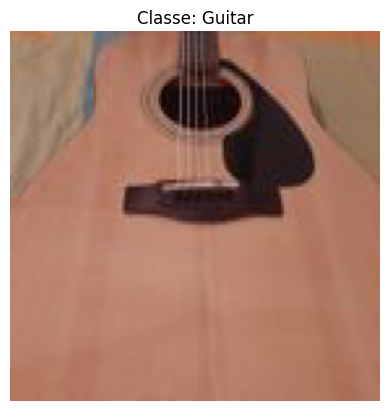

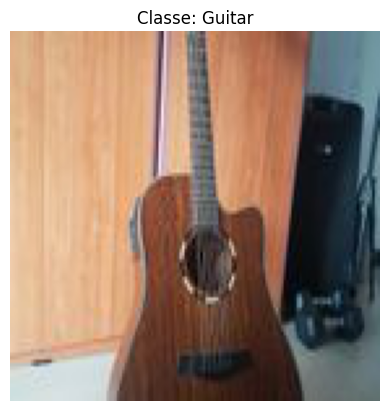

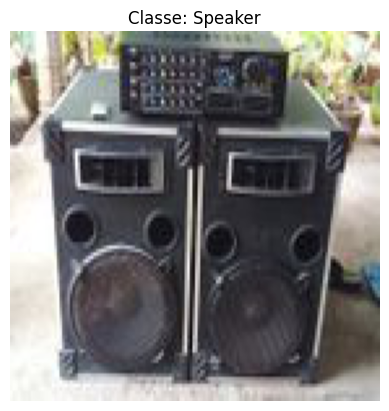

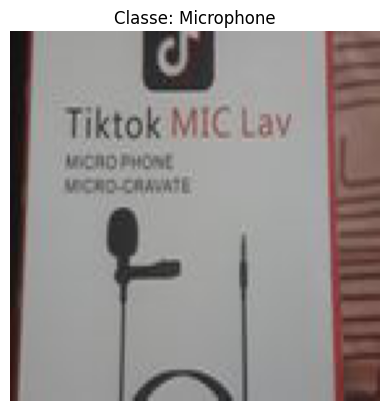

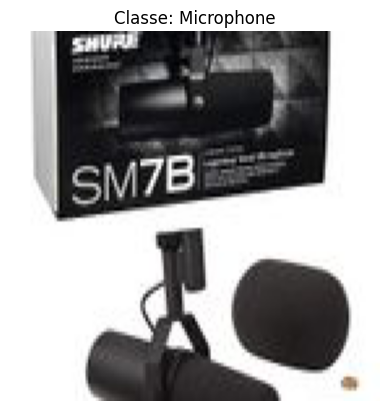

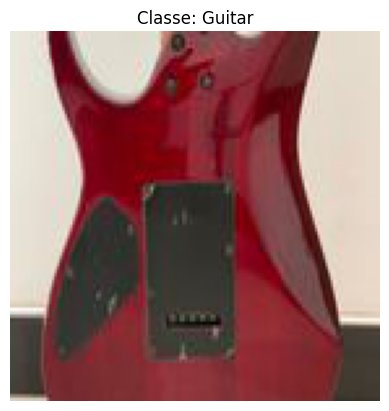

In [51]:
#Visualizando algumas imagens do conjunto de dados
import matplotlib.pyplot as plt
from PIL import Image
num_img = 10
for i, row in df.tail(num_img).iterrows():
    classe = row['class']
    img_name = row['images']
    img_path = os.path.join(path_train, img_name)
    img = Image.open(img_path)
    plt.imshow(img, extent=[0, 50, 0, 50])
    plt.title(f"Classe: {classe}")
    plt.axis("off")
    plt.show()